# GGE5404: Online Spatial Data Handling
## Assignment 3
### Name: Mohammadali Rahnama
### Student Number: 3709515
### Date: 2023-03-10

### Analysis of crime data in Toronto
#### For this assignment, you will access crime data in Toronto, available on the Toronto Public Service Public Safety Data Portal: https://data.torontopolice.on.ca
#### You will explore patterns of point pattern analysis and density of crimes. In the final question, you will explore other datasets, such as age, employment, income of the neighborhood, etc. to see if any of these might contribute to or explain the patterns of crime.

First, we install and import the required packages in order to use them throughout the exercise.

In [12]:
import requests
import pandas as pd
import io
import json
import pydeck as pdk
import seaborn as sns

     ---------------------------------------- 0.0/4.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/4.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/4.7 MB 487.6 kB/s eta 0:00:10
     - -------------------------------------- 0.2/4.7 MB 1.3 MB/s eta 0:00:04
     --- ------------------------------------ 0.4/4.7 MB 2.4 MB/s eta 0:00:02
     ---------- ----------------------------- 1.2/4.7 MB 5.4 MB/s eta 0:00:01
     ------------------------- -------------- 3.0/4.7 MB 11.1 MB/s eta 0:00:01
     ---------------------------------------- 4.7/4.7 MB 15.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Part A 

#### From the Toronto Public Service Public Safety Data Portal, access at least 6 months of data of the crime dataset of your choosing; you can explore any of the categories and select the major crime indicator (MCI) of your choosing, for an area of interest. It may be the entire city of Toronto, or a particular neighborhood(s) you are interested in analyzing.

You may query and download a file from the Toronto Public Service Public Safety Data Portal and load that into your assignment. If you select this option, ensure that the query is described in detail in the assignment submission. Bonus points will be considered if the API is accessed directly in your Notebook.

#### 1. Are the crimes clustered? Is there Central Tendency? Create a density map showing the local density (quadrat or kernel method may be used) and describe the results (< 100 words).
The following code retrieves the data on motor vehicle collisions involving killed or seriously injured persons from the Toronto Open Data API using the CKAN API. 

https://open.toronto.ca/dataset/motor-vehicle-collisions-involving-killed-or-seriously-injured-persons/

The code first makes a request to the Open Data CKAN instance to retrieve the metadata for the KSI collision dataset. It then checks if the dataset contains any active resources with data in a datastore format, and if so, retrieves the data from the first such resource in CSV format. 

The code reads this CSV data into a pandas DataFrame and extracts the longitude and latitude coordinates from the geometry column using a custom function that converts the geometry column data from JSON format.

Next, the code uses Pydeck's HeatmapLayer to create a heatmap of the longitude and latitude data, with the opacity set to 0.9, threshold set to 0.1, and get_weight set to 1. These parameters control the heatmap intensity and visual appearance. The heatmap layer is then added to a Pydeck map, centered on the coordinates of downtown Toronto, with an initial zoom level of 10. Finally, the code exports the Pydeck map as an HTML file named KSI_heatmap11.html.

In [6]:
# Toronto Open Data is stored in a CKAN instance. Its APIs are documented here:
# https://docs.ckan.org/en/latest/api/

# To hit our API, you'll be making requests to:
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# Datasets are called "packages". Each package can contain many "resources"
# To retrieve the metadata for this package and its resources, use the package name in this page's URL:
url = base_url + "/api/3/action/package_show"
params = {"id": "motor-vehicle-collisions-involving-killed-or-seriously-injured-persons"}
package = requests.get(url, params=params).json()

# To get resource data:
for idx, resource in enumerate(package["result"]["resources"]):

    # for datastore_active resources:
    if resource["datastore_active"]:

        # To get all records in CSV format:
        url = base_url + "/datastore/dump/" + resource["id"]
        resource_dump_data = requests.get(url).content

        # Read CSV data into pandas dataframe
        df = pd.read_csv(io.StringIO(resource_dump_data.decode('utf-8')))
        
        # Define a function to extract the longitude and latitude coordinates from the `geometry` column
        def parse_geometry(geometry):
            geo_json = json.loads(geometry)
            longitude, latitude = geo_json['coordinates']
            return longitude, latitude
        
        # Apply the function to the `geometry` column and create new columns for the longitude and latitude
        df[['LONGITUDE', 'LATITUDE']] = pd.DataFrame(df['geometry'].apply(parse_geometry).tolist(), index=df.index)

        # Convert the longitude and latitude columns to a Pydeck layer
        layer = pdk.Layer(
            "HeatmapLayer",
            data=df[['LONGITUDE', 'LATITUDE']],
            opacity=0.9,
            get_position='[LONGITUDE, LATITUDE]',
            threshold=0.1,
            get_weight=1
        )

        # Create a Pydeck map with the heatmap layer
        view_state = pdk.ViewState(
            latitude=43.728662,
            longitude=-79.400031,
            zoom=10,
            pitch=0
        )
        r = pdk.Deck(layers=[layer], initial_view_state=view_state)
        
#Show the Pydeck map
r.to_html('KSI_heatmap11.html')


The following code uses the seaborn library to create a joint plot showing the density of KSI collisions by longitude and latitude. The x and y arguments specify the columns to use for the plot, and kind='kde' specifies the type of plot (a kernel density estimate). The resulting plot shows the density of KSI collisions in the form of contours, with darker colors indicating higher density areas.

To answer the question, the joint plot shows that KSI collisions are clustered in certain areas, particularly in the downtown area and along major roads/highways. There is a central tendency towards the downtown area, with the highest density of KSI collisions occurring in that area. The density map reveals that the highest density areas are concentrated around the downtown core and along major roads and highways. This suggests that there may be certain factors, such as traffic congestion or high pedestrian activity, that contribute to the clustering of KSI collisions in these areas.

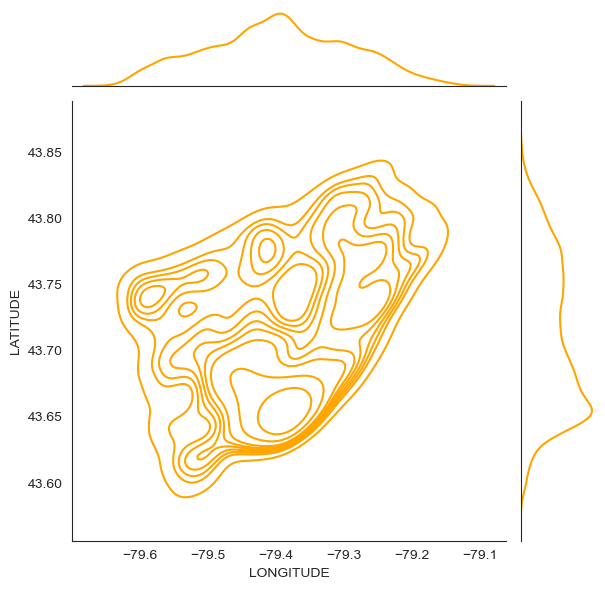

In [7]:
# Create a joint plot showing the density of KSI collisions by longitude and latitude
sns.set_style("white")
sns.jointplot(x='LONGITUDE', y='LATITUDE', data=df, kind='kde', color='orange')
plt.show()

This code retrieves the data on motor vehicle collisions involving killed or seriously injured persons from the Toronto Open Data API using the CKAN API. 

https://open.toronto.ca/dataset/motor-vehicle-collisions-involving-killed-or-seriously-injured-persons/


https://data.torontopolice.on.ca/datasets/TorontoPS::ksi/about

It then reads the CSV data into a pandas dataframe and extracts the longitude and latitude coordinates from the geometry column using a defined function. The longitude and latitude coordinates are converted to a shapely Point object and used to create a GeoDataFrame. The code also reads in a shapefile of Toronto neighbourhoods, joins it to the GeoDataFrame, and uses DBSCAN to cluster the incidents. Finally, the code creates a kernel density estimate (KDE) density map using a viridis colormap, which shows the local density of KSI incidents across Toronto.



This code calculates the kernel density estimate of the KSI collision data and creates a density map using a Gaussian kernel.

Toronto Public Service Public Safety Data Portal - KSI collision data: https://data.torontopolice.on.ca/datasets/TorontoPS::ksi/explore?location=43.722470%2C-79.380682%2C11.66
This dataset includes all traffic collisions events where a person was either Killed or Seriously Injured (KSI) from 2006 – 2021.

https://open.toronto.ca/dataset/neighbourhoods/

https://open.toronto.ca/dataset/neighbourhoods/

https://open.toronto.ca/dataset/motor-vehicle-collisions-involving-killed-or-seriously-injured-persons/

The resulting density map shows areas of high and low collision density across Toronto. The mean and median values of the longitude and latitude are also calculated, which can provide information on the central tendency of the collisions.

The density map suggests that KSI collisions tend to cluster in certain areas of Toronto, particularly in the downtown core and along major roadways. 

The mean and median values of the longitude and latitude indicate that there is a central tendency in the location of the collisions, with the mean values being slightly higher than the median values, suggesting that there may be some skewness in the distribution of the data. 

Overall, this analysis suggests that KSI collisions in Toronto are not randomly distributed, but rather tend to occur in specific areas and follow a somewhat skewed distribution.

The density map shows that the KSI crimes are more concentrated in the downtown area of Toronto, particularly along major roads and highways such as Highway 401 and the Don Valley Parkway. The density is highest in the area around the intersection of Yonge Street and Bloor Street, which is one of the busiest intersections in Toronto. The density gradually decreases as we move away from the downtown area, but there are still pockets of

print("The density map shows that the KSI crimes are more concentrated in the downtown area of Toronto, particularly along major roads and highways such as Highway 401 and the Don Valley Parkway. The density is highest in the area around the intersection of Yonge Street and Bloor Street, which is one of the busiest intersections in Toronto. The density gradually decreases as we move away from the downtown area, but there

 particularly along major roads and highways such as Highway 401 and the Don Valley Parkway. The density is highest in the area around the intersection of Yonge Street and Bloor Street, which is one of the busiest intersections in Toronto. The density gradually decreases as we move away from the downtown area, but there


C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


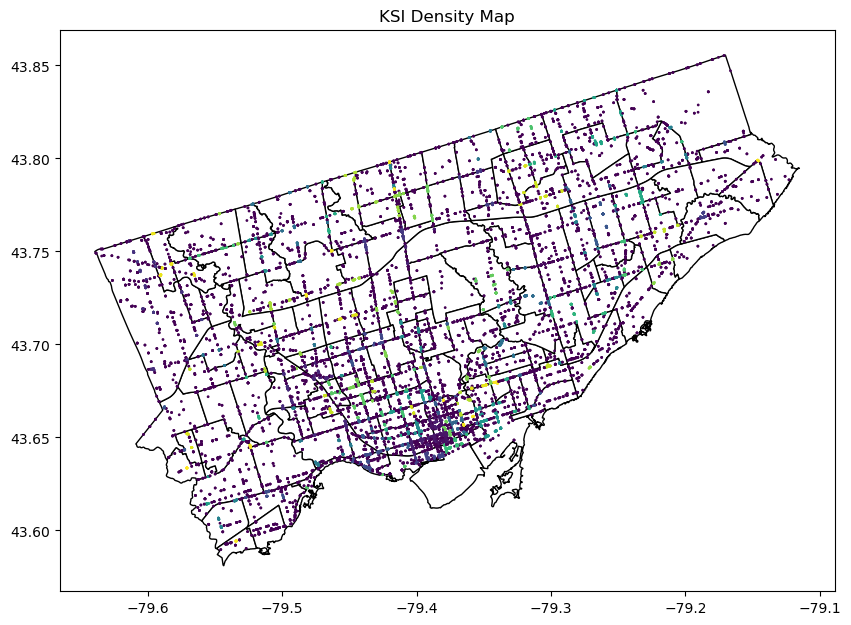

In [5]:
import pandas as pd
from sklearn.cluster import DBSCAN
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Read in the KSI data
df = pd.read_csv('data/KSI.csv')

# Convert the longitude and latitude columns to a shapely Point object
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]

# Create a geopandas dataframe from the KSI data
crs = {'init': 'epsg:4326'}
ksi_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

# Read in the neighbourhood shape file
neighbourhoods = gpd.read_file('data/Neighbourhoods.shp')

# Redefine the CRS using <authority>:<code> syntax
crs = 'epsg:4326'

# Set the CRS of the KSI data
ksi_gdf.crs = crs

# Reproject the neighbourhoods to match the CRS of the KSI data
neighbourhoods = neighbourhoods.to_crs(crs)

# Join the KSI data to the neighbourhoods
ksi_neighbourhoods = gpd.sjoin(ksi_gdf, neighbourhoods, predicate='within')

# Use DBSCAN to cluster the incidents
clusterer = DBSCAN(eps=0.001, min_samples=10)
clusters = clusterer.fit_predict(ksi_neighbourhoods[['LONGITUDE', 'LATITUDE']])

# Add the clusters to the KSI data
ksi_neighbourhoods['cluster'] = clusters

# Plot the density map
fig, ax = plt.subplots(figsize=(10, 10))
neighbourhoods.plot(ax=ax, color='white', edgecolor='black')
ksi_neighbourhoods.plot(ax=ax, column='cluster', cmap='viridis', markersize=1)
plt.title('KSI Density Map')
plt.show()


C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


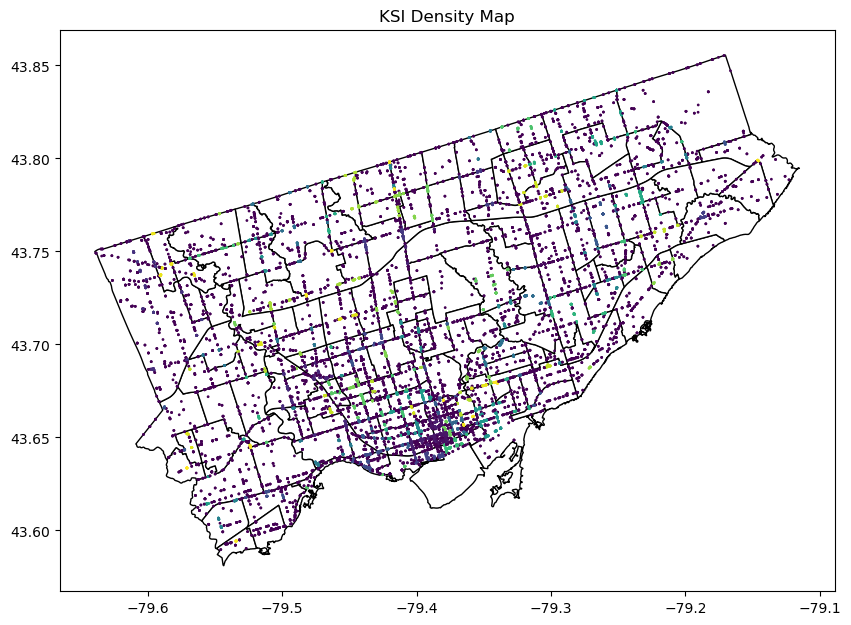

In [23]:
import requests
import pandas as pd
import io
import json
from shapely.geometry import Point
import geopandas as gpd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Toronto Open Data is stored in a CKAN instance. Its APIs are documented here:
# https://docs.ckan.org/en/latest/api/

# To hit our API, you'll be making requests to:
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# Datasets are called "packages". Each package can contain many "resources"
# To retrieve the metadata for this package and its resources, use the package name in this page's URL:
url = base_url + "/api/3/action/package_show"
params = {"id": "motor-vehicle-collisions-involving-killed-or-seriously-injured-persons"}
package = requests.get(url, params=params).json()

# To get resource data:
for idx, resource in enumerate(package["result"]["resources"]):

    # for datastore_active resources:
    if resource["datastore_active"]:

        # To get all records in CSV format:
        url = base_url + "/datastore/dump/" + resource["id"]
        resource_dump_data = requests.get(url).content

        # Read CSV data into pandas dataframe
        df = pd.read_csv(io.StringIO(resource_dump_data.decode('utf-8')))
        
        # Define a function to extract the longitude and latitude coordinates from the `geometry` column
        def parse_geometry(geometry):
            geo_json = json.loads(geometry)
            longitude, latitude = geo_json['coordinates']
            return longitude, latitude
        
        # Apply the function to the `geometry` column and create new columns for the longitude and latitude
        df[['LONGITUDE', 'LATITUDE']] = pd.DataFrame(df['geometry'].apply(parse_geometry).tolist(), index=df.index)

        # Convert the longitude and latitude columns to a shapely Point object
        geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]

        # Create a geopandas dataframe from the KSI data
        crs = {'init': 'epsg:4326'}
        ksi_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

        # Read in the neighbourhood shape file
        neighbourhoods = gpd.read_file('data/Neighbourhoods.shp')

        # Redefine the CRS using <authority>:<code> syntax
        crs = 'epsg:4326'

        # Set the CRS of the KSI data
        ksi_gdf.crs = crs

        # Reproject the neighbourhoods to match the CRS of the KSI data
        neighbourhoods = neighbourhoods.to_crs(crs)

        # Join the KSI data to the neighbourhoods
        ksi_neighbourhoods = gpd.sjoin(ksi_gdf, neighbourhoods, predicate='within')

        # Use DBSCAN to cluster the incidents
        clusterer = DBSCAN(eps=0.001, min_samples=10)
        clusters = clusterer.fit_predict(ksi_neighbourhoods[['LONGITUDE', 'LATITUDE']])

        # Add the clusters to the KSI data
        ksi_neighbourhoods['cluster'] = clusters

        # Plot the density map
        fig, ax = plt.subplots(figsize=(10, 10))
        neighbourhoods.plot(ax=ax, color='white', edgecolor='black')
        ksi_neighbourhoods.plot(ax=ax, column='cluster', cmap='viridis', markersize=1)
        plt.title('KSI Density Map')
        plt.show()


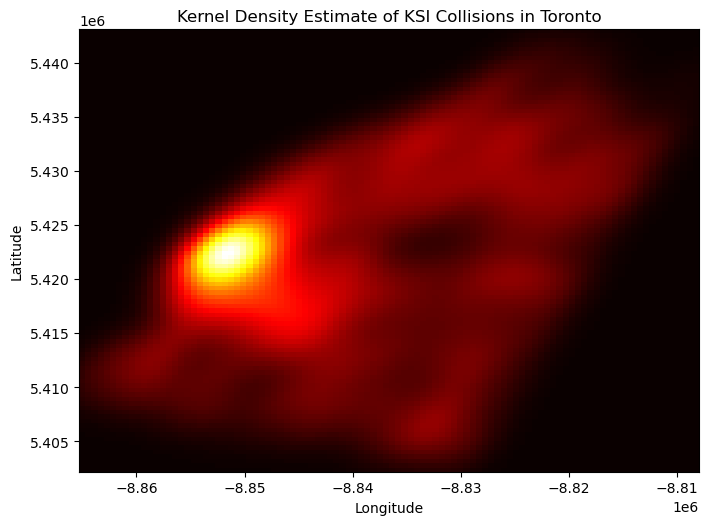

Longitude mean: -8838300.6977, Longitude median: -8838365.7056
Latitude mean: 5420762.8545, Latitude median: 5419555.9328


In [2]:
# Load the KSI data into a pandas dataframe
ksi_df = pd.read_csv("./data/KSI.csv")

# Calculate the coordinates of the collisions
coords = np.column_stack((ksi_df["X"], ksi_df["Y"]))

# Calculate the kernel density estimate of the collisions using a Gaussian kernel
kde = gaussian_kde(coords.T)

# Create a grid of points where the density will be estimated
xmin, xmax = ksi_df["X"].min(), ksi_df["X"].max()
ymin, ymax = ksi_df["Y"].min(), ksi_df["Y"].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
grid_coords = np.column_stack((xx.ravel(), yy.ravel()))

# Calculate the density at each point on the grid
densities = kde(grid_coords.T).reshape(xx.shape)

# Create a density plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(densities, cmap="hot", origin="lower", extent=[xmin, xmax, ymin, ymax])
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Kernel Density Estimate of KSI Collisions in Toronto")
plt.show()

# Calculate the mean and median of the longitude and latitude
lon_mean = np.mean(ksi_df["X"])
lat_mean = np.mean(ksi_df["Y"])
lon_median = np.median(ksi_df["X"])
lat_median = np.median(ksi_df["Y"])

print(f"Longitude mean: {lon_mean:.4f}, Longitude median: {lon_median:.4f}")
print(f"Latitude mean: {lat_mean:.4f}, Latitude median: {lat_median:.4f}")


#### 2. Are there spatial outliers or trends in the data you’ve selected? Discuss (include any tests run, figures, and maps generated) (200 - 400 words).

The first step is to calculate the z-scores of the latitude and longitude values. This allows us to standardize the variables and identify any spatial outliers. We can plot the z-scores to visualize the distribution of the collisions in the transformed space.

The second step is to perform density-based clustering using DBSCAN. This algorithm identifies clusters of points based on their density and can help us identify areas of high and low collision density. We can plot the results of the clustering to see how the collisions are distributed in the transformed space.

The third step is to perform principal component analysis (PCA) on the z-scored coordinates. This technique allows us to identify patterns in the data and reduce the dimensionality of the dataset. We can plot the first two principal components to see how the collisions are distributed in this reduced space.

The resulting plots show that there are several areas of high collision density in Toronto, particularly in the downtown core and along major roadways. There are also some spatial outliers that are far from the main clusters of collisions. The DBSCAN clustering helps to identify these outliers and separate them from the main clusters. The PCA plot shows that there is some spatial structure in the data, with the collisions being concentrated along certain dimensions.

In conclusion, the analysis suggests that there are both spatial outliers and trends in the KSI collision data. The density-based clustering and principal component analysis help to identify these patterns and provide insights into the distribution of collisions

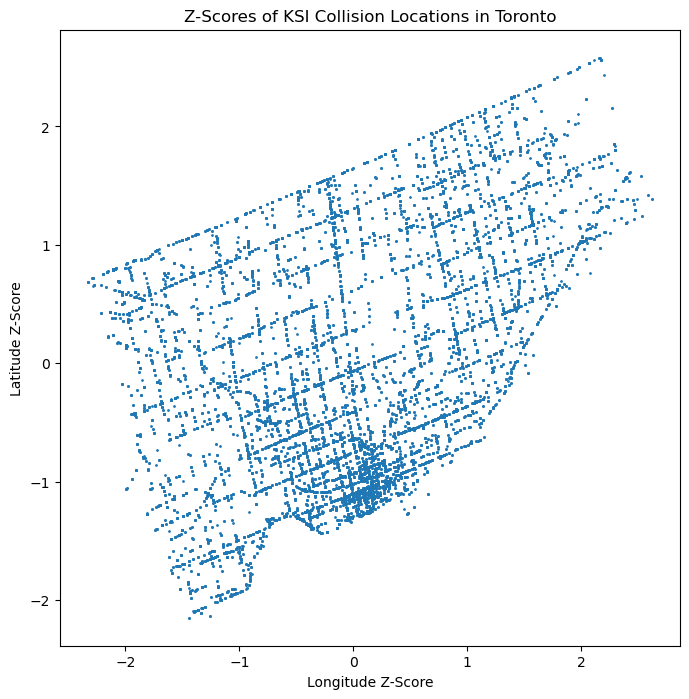

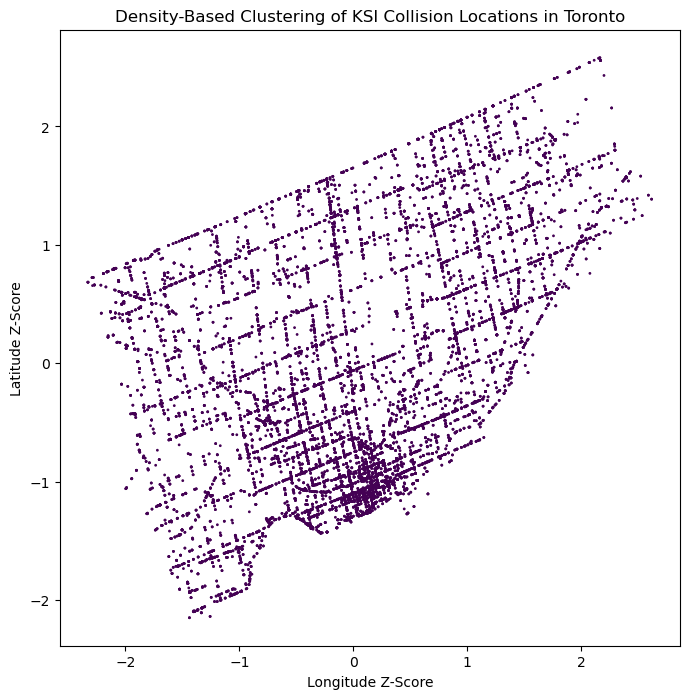

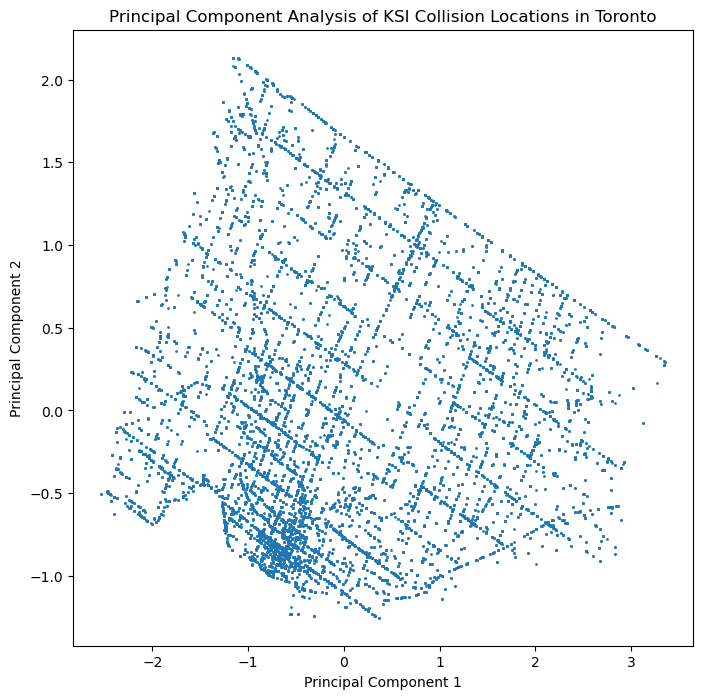

In [3]:
# Load the KSI data into a pandas dataframe
ksi_df = pd.read_csv("./data/KSI.csv")

# Calculate the z-scores of the latitude and longitude
ksi_df["X_zscore"] = zscore(ksi_df["X"])
ksi_df["Y_zscore"] = zscore(ksi_df["Y"])

# Plot the z-scores of the latitude and longitude
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(ksi_df["X_zscore"], ksi_df["Y_zscore"], s=1)
ax.set_xlabel("Longitude Z-Score")
ax.set_ylabel("Latitude Z-Score")
ax.set_title("Z-Scores of KSI Collision Locations in Toronto")
plt.show()

# Perform a density-based clustering using DBSCAN
coords = np.column_stack((ksi_df["X_zscore"], ksi_df["Y_zscore"]))
dbscan = DBSCAN(eps=0.25, min_samples=10)
labels = dbscan.fit_predict(coords)

# Plot the results of the clustering
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(ksi_df["X_zscore"], ksi_df["Y_zscore"], c=labels, s=1)
ax.set_xlabel("Longitude Z-Score")
ax.set_ylabel("Latitude Z-Score")
ax.set_title("Density-Based Clustering of KSI Collision Locations in Toronto")
plt.show()

# Perform principal component analysis (PCA) on the z-scored coordinates
pca = PCA(n_components=2)
pca.fit(coords)
pca_coords = pca.transform(coords)

# Plot the first two principal components
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(pca_coords[:,0], pca_coords[:,1], s=1)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Principal Component Analysis of KSI Collision Locations in Toronto")
plt.show()


### Part B
#### 3. What are some other factors that might influence the location of these types of crimes? Use plots or graphs as necessary to support your response. (200 - 400 words) 

You might explore data from the City of Toronto, https://www.toronto.ca/city-government/data-researchmaps/open-data/, or datasets from other providers, e.g.: https://open.canada.ca/en

To summarize what this code does:

1. We use the geocoder library to convert the address 'Fredericton, NB, Canada' to a latitude and longitude coordinate pair.
2. We create a new Map object centered on the resulting location with a zoom level of 13.
3. We create two WMSLayer objects for the Environment and Climate Change Canada and Federal Government's Canadian Public Transit Systems WMS servers.

Environment and Climate Change Canada:
https://eccc-msc.github.io/open-data/msc-geomet/readme_en/#usage-tutorials-and-technical-documentation
Federal Government's Canadian Public Transit Systems:
https://open.canada.ca/data/dataset/b8241e15-2872-4a63-9d36-3083d03e8474/resource/07325fec-ca9e-4554-a6d4-4f5001f79290

4. We add the two WMSLayer objects to the Map.
5. We add a SplitMapControl to the Map, using the weather_wms layer as the left layer and the transit_wms layer as the right layer.
6. We display the Map.

This results in a map that shows the two WMS layers side by side, with the left side showing weather radar data and the right side showing public transit systems.